# Keras AutoEncoder 

Autoencoder in keras to test GPU instances on AWS/GCP

In [1]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop, SGD, Adam

Using plaidml.keras.backend backend.


In [2]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data

In [3]:
train_data = extract_data('train-images-idx3-ubyte.gz', 60000)
test_data = extract_data('t10k-images-idx3-ubyte.gz', 10000)

In [4]:
def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

In [5]:
train_labels = extract_labels('train-labels-idx1-ubyte.gz',60000)
test_labels = extract_labels('t10k-labels-idx1-ubyte.gz',10000)

In [6]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=train_data.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=test_data.shape))

Training set (images) shape: (60000, 28, 28)
Test set (images) shape: (10000, 28, 28)


In [7]:
# Create dictionary of target classes
label_dict = {
 0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
}

Text(0.5,1,'(Label: 7)')

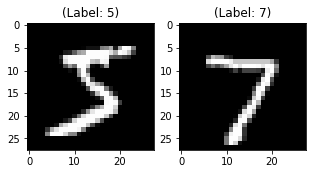

In [8]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_data[0], (28,28))
curr_lbl = train_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test_data[0], (28,28))
curr_lbl = test_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

In [9]:
train_data = train_data.reshape(-1, 28,28, 1)
test_data = test_data.reshape(-1, 28,28, 1)
train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [10]:
train_data.dtype, test_data.dtype

(dtype('float32'), dtype('float32'))

In [11]:
np.max(train_data), np.max(test_data)

(255.0, 255.0)

In [12]:
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

In [13]:
np.max(train_data), np.max(test_data)

(1.0, 1.0)

In [14]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data, 
                                                             test_size=0.2, 
                                                             random_state=13)

In [15]:
batch_size = 256
epochs = 50
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel), dtype='float32')

In [16]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [17]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = SGD())

INFO:plaidml:Opening device "metal_amd_radeon_rx_580.0"


In [18]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         147584    
__________

In [19]:
autoencoder_train = autoencoder.fit(train_X, 
                                    train_ground, 
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(valid_X, valid_ground))


Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 28s 580us/step - loss: 0.1749 - val_loss: 0.1293
Epoch 2/50
48000/48000 [==============================] - 16s 340us/step - loss: 0.1179 - val_loss: 0.1120
Epoch 3/50
48000/48000 [==============================] - 16s 340us/step - loss: 0.1072 - val_loss: 0.1023
Epoch 4/50
48000/48000 [==============================] - 16s 339us/step - loss: 0.0945 - val_loss: 0.0854
Epoch 5/50
48000/48000 [==============================] - 16s 339us/step - loss: 0.0734 - val_loss: 0.0622
Epoch 6/50
48000/48000 [==============================] - 16s 339us/step - loss: 0.0546 - val_loss: 0.0492
Epoch 7/50
48000/48000 [==============================] - 16s 340us/step - loss: 0.0458 - val_loss: 0.0434
Epoch 8/50
48000/48000 [==============================] - 16s 340us/step - loss: 0.0413 - val_loss: 0.0397
Epoch 9/50
48000/48000 [==============================] - 16s 341us/step - loss: 0.0381 - val_

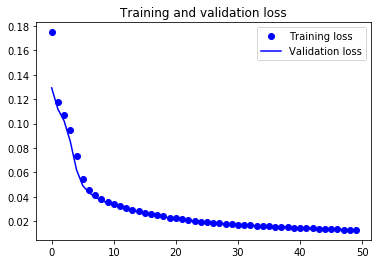

In [20]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [21]:
pred = autoencoder.predict(test_data)

In [22]:
pred.shape

(10000, 28, 28, 1)

Test Images


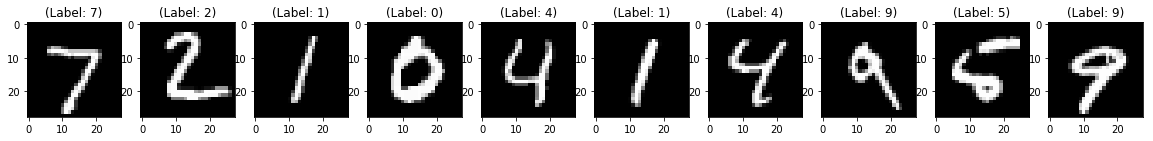

Reconstruction of Test Images


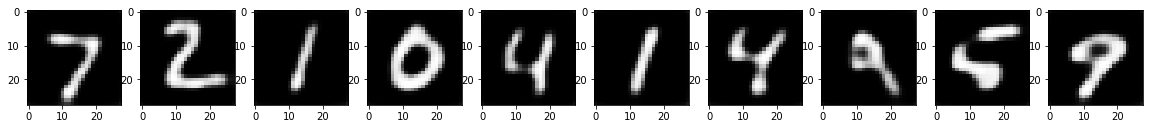

array([[[5.45564704e-02],
        [1.57865342e-02],
        [9.97128710e-03],
        [6.02977723e-03],
        [4.49313084e-03],
        [3.01858014e-03],
        [2.12788489e-03],
        [1.53283146e-03],
        [1.24897540e-03],
        [1.07706990e-03],
        [1.00390892e-03],
        [1.05583994e-03],
        [1.09034905e-03],
        [1.22671912e-03],
        [1.31827977e-03],
        [1.46113918e-03],
        [1.54411583e-03],
        [1.61317410e-03],
        [1.62646745e-03],
        [1.72890816e-03],
        [1.86044921e-03],
        [2.33164569e-03],
        [3.01652169e-03],
        [4.07092972e-03],
        [5.25905285e-03],
        [9.34137590e-03],
        [1.52807683e-02],
        [5.50379753e-02]],

       [[1.45600867e-02],
        [2.19903467e-03],
        [1.07329572e-03],
        [4.96640627e-04],
        [3.30681622e-04],
        [1.95964880e-04],
        [1.26130282e-04],
        [8.00303242e-05],
        [5.83449255e-05],
        [4.53819375e-05],
        [3

In [23]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i, ..., 0], cmap='gray')
    curr_lbl = test_labels[i]
    plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show();
pred[0]

In [24]:
noise_factor = 0.5
x_train_noisy = train_X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_X.shape)
x_valid_noisy = valid_X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=valid_X.shape)
x_test_noisy = test_data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_data.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

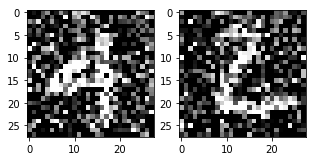

In [25]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(x_train_noisy[1], (28,28))
plt.imshow(curr_img, cmap='gray')

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(x_test_noisy[1], (28,28))
plt.imshow(curr_img, cmap='gray')

In [26]:
batch_size = 128
epochs = 20
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))


In [27]:
def autoencoder2(input_img):
    #encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    up1 = UpSampling2D((2,2))(conv4)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2,2))(conv5)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)
    return decoded

In [28]:
autoencoder = Model(input_img, autoencoder2(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = SGD())

In [29]:
autoencoder_train = autoencoder.fit(x_train_noisy, train_X, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_valid_noisy, valid_X))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 24s 503us/step - loss: 0.1358 - val_loss: 0.1159
Epoch 2/20
48000/48000 [==============================] - 18s 374us/step - loss: 0.1091 - val_loss: 0.1014
Epoch 3/20
48000/48000 [==============================] - 18s 375us/step - loss: 0.0876 - val_loss: 0.0722
Epoch 4/20
48000/48000 [==============================] - 18s 375us/step - loss: 0.0613 - val_loss: 0.0540
Epoch 5/20
48000/48000 [==============================] - 18s 373us/step - loss: 0.0497 - val_loss: 0.0469
Epoch 6/20
48000/48000 [==============================] - 18s 374us/step - loss: 0.0448 - val_loss: 0.0435
Epoch 7/20
48000/48000 [==============================] - 18s 373us/step - loss: 0.0420 - val_loss: 0.0411
Epoch 8/20
48000/48000 [==============================] - 18s 372us/step - loss: 0.0400 - val_loss: 0.0394
Epoch 9/20
48000/48000 [==============================] - 18s 371us/step - loss: 0.0382 - val_

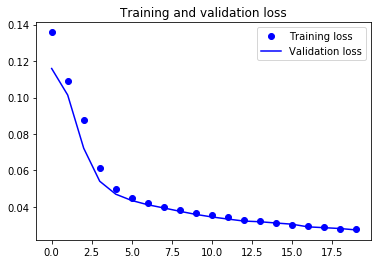

In [30]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [31]:
pred = autoencoder.predict(x_test_noisy)

Test Images


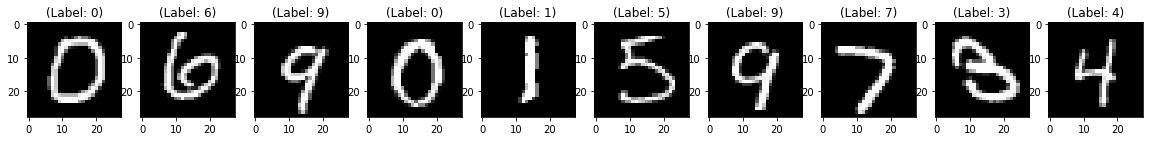

Test Images with Noise


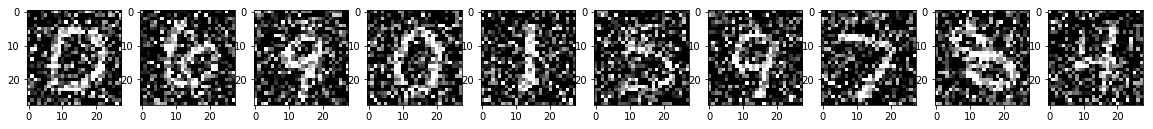

Reconstruction of Noisy Test Images


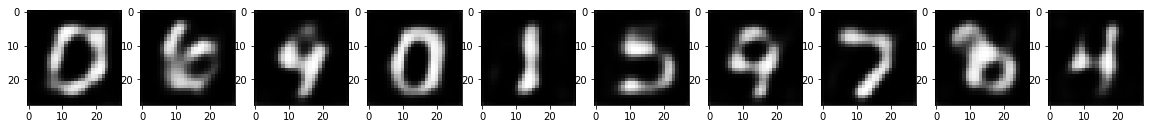

In [32]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i, ..., 0], cmap='gray')
    curr_lbl = test_labels[i]
    plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
plt.show()    
plt.figure(figsize=(20, 4))
print("Test Images with Noise")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_noisy[i, ..., 0], cmap='gray')
plt.show()    

plt.figure(figsize=(20, 4))
print("Reconstruction of Noisy Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()